### Dependencies

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from seaborn import countplot
import matplotlib.pyplot as plt
from keras import optimizers
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, Activation, BatchNormalization
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


### Auxiliar functions

In [2]:
def plot_metrics_primary(acc, val_acc, loss, val_loss):
    fig, (ax1, ax2) = plt.subplots(1, 2, sharex='col', figsize=(20,7))

    ax1.plot(acc, label='Train Accuracy')
    ax1.plot(val_acc, label='Validation accuracy')
    ax1.legend(loc='best')
    ax1.set_title('Accuracy')

    ax2.plot(loss, label='Train loss')
    ax2.plot(val_loss, label='Validation loss')
    ax2.legend(loc='best')
    ax2.set_title('Loss')

    plt.xlabel('Epochs')
    
    
def plot_confusion_matrix(cnf_matrix, labels): 
    cnf_matrix_norm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
    df_cm = pd.DataFrame(cnf_matrix_norm, index=labels, columns=labels)
    plt.figure(figsize=(20,7))
    sns.heatmap(df_cm, annot=True, fmt='.2f', cmap="Blues")

### Parameters

In [3]:
TRAIN_PATH = '../input/train.csv'
TEST_PATH = '../input/test.csv'
SUBMISSION_NAME = 'submission.csv'

# Model parameters
BATCH_SIZE = 64
EPOCHS = 45
LEARNING_RATE = 0.001
HEIGHT = 28
WIDTH = 28
CANAL = 1
N_CLASSES = 10

### Load data

In [4]:
train = pd.read_csv(TRAIN_PATH)
test = pd.read_csv(TEST_PATH)
labels = train['label']
train = train.drop(['label'], axis=1)

### Let's take a look at the data

In [5]:
train.head(5)

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [6]:
train.shape

(42000, 784)

As we can see we have 42000 records on the train data, and our data is just a bunch of pixels (784 per image to be more exactly), each image comes as a 28x28 matrix of pixels.

Let's take a look at our train data by label category.

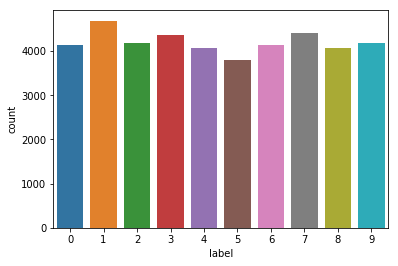

In [7]:
countplot(labels)

In [8]:
labels.value_counts()

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

We have less labels 5 but luckily we won't have to deal with highly imbalanced data, this will make our work easier.

### Reshape data

In [9]:
# Reshape image in 3 dimensions (height, width, canal)
train = train.values.reshape(-1,HEIGHT,WIDTH,CANAL)
test = test.values.reshape(-1,HEIGHT,WIDTH,CANAL)
# Turn labels into np arrays
labels = labels.values

In [10]:
train.shape

(42000, 28, 28, 1)

Would be better to visualize some of the records as a images.

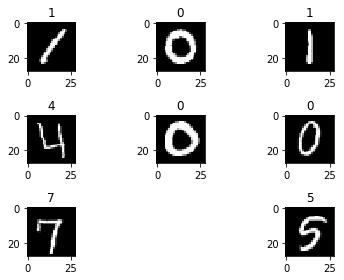

In [11]:
for i in range(9):
    plt.subplot(330 + (i+1))
    plt.imshow(train[i][:,:,0], cmap=plt.get_cmap('gray'))
    plt.tight_layout()
    plt.title(labels[i]);

For a human label these would be a easy task, but can our model perform well enought?

### One-hot encode the labels

In [12]:
labels = pd.get_dummies(labels).as_matrix()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


### Normalize data
* Normalizing data should improve our model convergence time.

In [13]:
train = train / 255.0
test = test / 255.0

### Split data in train and validation (90% ~ 10%)

In [14]:
x_train, x_val, y_train, y_val = train_test_split(train, labels, test_size=0.1, random_state=1)

### Data augmentation
* Data augmentation is used to create more data from the current set we have, here, using the Keras API for data augmentation (ImageDataGenerator), we can generate more samples while feeding the model, the new data is created adding some noise to the real data.
* In this case data augmentation seems to be very useful, as we saw most of the data seems to be the original one but with a bit of distortion.

In [15]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.15, # Randomly zoom image 
        width_shift_range=0.15,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.15)  # randomly shift images vertically (fraction of total height)

datagen.fit(x_train)

### Model

In [16]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(5,5),padding='Same', input_shape=(HEIGHT, WIDTH, CANAL)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(filters=32, kernel_size=(5,5),padding='Same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=64, kernel_size=(3,3),padding='Same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(filters=64, kernel_size=(3,3),padding='Same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(N_CLASSES, activation = "softmax"))

optimizer = optimizers.adam(lr=LEARNING_RATE)
model.compile(optimizer=optimizer , loss="categorical_crossentropy", metrics=["accuracy"])

Let's take a look at our model parameters:

In [17]:
print('Dataset size: %s' % train.shape[0])
print('Epochs: %s' % EPOCHS)
print('Learning rate: %s' % LEARNING_RATE)
print('Batch size: %s' % BATCH_SIZE)
print('Input dimension: (%s, %s, %s)' % (HEIGHT, WIDTH, CANAL))

Dataset size: 42000
Epochs: 45
Learning rate: 0.001
Batch size: 64
Input dimension: (28, 28, 1)


In [18]:
x_train[0].shape

(28, 28, 1)

In [19]:
history = model.fit_generator(datagen.flow(x_train,y_train, batch_size=BATCH_SIZE),
                              epochs=EPOCHS, validation_data=(x_val, y_val),
                              verbose=2, steps_per_epoch=x_train.shape[0] // BATCH_SIZE)

Epoch 1/45
 - 22s - loss: 0.4241 - acc: 0.8675 - val_loss: 0.0662 - val_acc: 0.9793
Epoch 2/45
 - 17s - loss: 0.1469 - acc: 0.9562 - val_loss: 0.0379 - val_acc: 0.9876
Epoch 3/45
 - 17s - loss: 0.1139 - acc: 0.9668 - val_loss: 0.0704 - val_acc: 0.9776
Epoch 4/45
 - 17s - loss: 0.0932 - acc: 0.9714 - val_loss: 0.0372 - val_acc: 0.9881
Epoch 5/45
 - 17s - loss: 0.0900 - acc: 0.9730 - val_loss: 0.0305 - val_acc: 0.9893
Epoch 6/45
 - 17s - loss: 0.0794 - acc: 0.9754 - val_loss: 0.0292 - val_acc: 0.9905
Epoch 7/45
 - 17s - loss: 0.0725 - acc: 0.9779 - val_loss: 0.0440 - val_acc: 0.9860
Epoch 8/45
 - 17s - loss: 0.0687 - acc: 0.9793 - val_loss: 0.0253 - val_acc: 0.9929
Epoch 9/45
 - 18s - loss: 0.0648 - acc: 0.9802 - val_loss: 0.0236 - val_acc: 0.9921
Epoch 10/45
 - 17s - loss: 0.0616 - acc: 0.9813 - val_loss: 0.0204 - val_acc: 0.9936
Epoch 11/45
 - 17s - loss: 0.0597 - acc: 0.9821 - val_loss: 0.0242 - val_acc: 0.9933
Epoch 12/45
 - 17s - loss: 0.0546 - acc: 0.9830 - val_loss: 0.0230 - val_a

Let's take a look at our model loss and accuracy training graph.

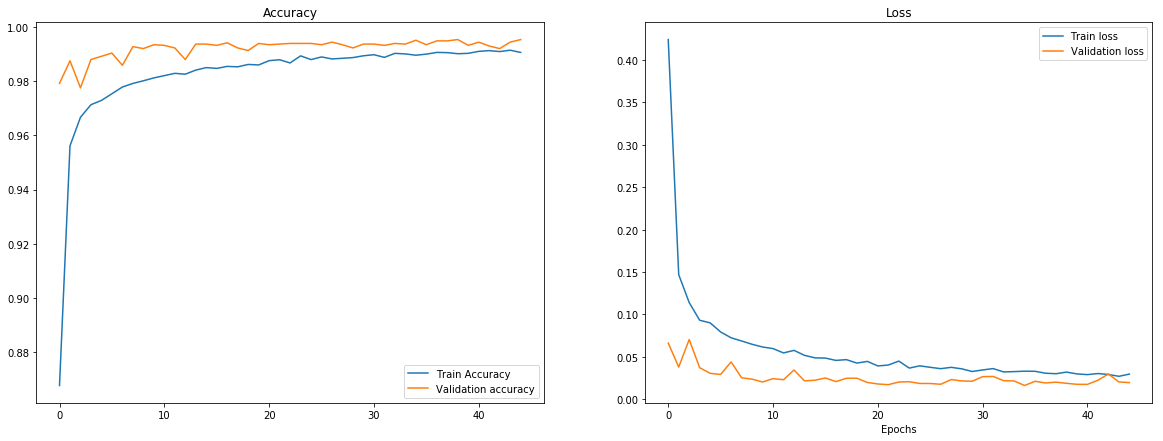

In [20]:
plot_metrics_primary(history.history['acc'], history.history['val_acc'], history.history['loss'], history.history['val_loss'])

A good way to evaluate a classification model is to take a look at the model confusion matrix, this way we can have a better insight on what our model is getting right and what not.

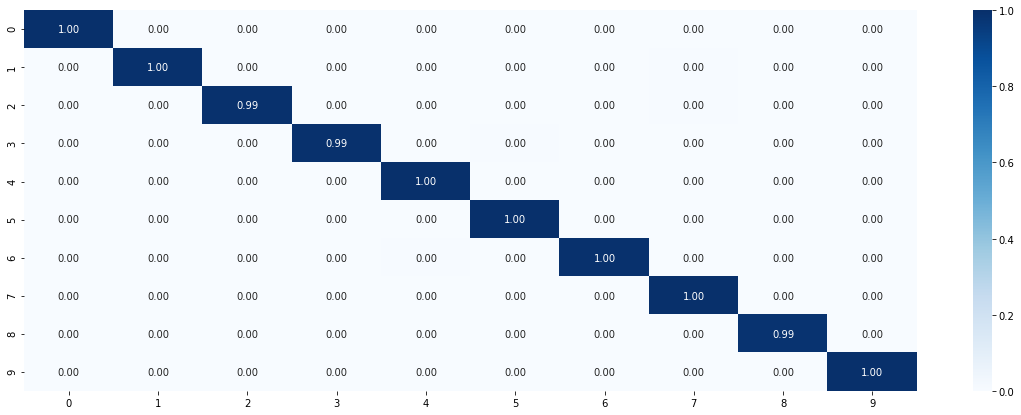

In [21]:
cnf_matrix = confusion_matrix(np.argmax(y_val, axis=1), model.predict_classes(x_val))
plot_confusion_matrix(cnf_matrix, range(10))

It seems we had pretty good results, we don't have any big confusion between labels, nice!

Finally let's predict the test data and output our predictions.

In [22]:
predictions = model.predict_classes(test)

In [25]:
submission = pd.DataFrame({"ImageId": list(range(1, len(predictions) + 1)), "Label": predictions})
submission.to_csv(SUBMISSION_NAME, index=False)
submission.head(10)

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3
5,6,7
6,7,0
7,8,3
8,9,0
9,10,3
